In [1]:
import urllib, json, copy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
areas = gpd.read_file( '../../data/aree.geojson' )
areas = areas[["geometry", "NOME_AT"]] # shows epsg:3004, but it's wrong
areas = areas.rename(columns = { "NOME_AT" : "frazione" })
areas = areas.set_crs( "epsg:4326", allow_override = True )
areas = areas.to_crs( epsg = 32633 ) #utm
tot_areas = areas.area.sum() / 10**6 #kmq
# print(tot_areas)

In [3]:
points_url = 'https://opendata.comune.ra.it/dataset/01a9ed32-3b1c-4d0c-b20f-ef0fb5d22c4e/resource/6d4f0753-27af-4d70-aed9-f253c8da4c4f/download/aree_verdi.geojson'
points_response = urllib.request.urlopen(points_url)
points_data = json.loads(points_response.read())
# print(points_data)
points = gpd.GeoDataFrame.from_features(points_data)
points = points.rename(columns = { 'TIPO' : 'type', 'SOTTOTIPO' : 'cat' })
# print(points.crs)
points = points.set_crs('epsg:3004')
points = points.to_crs(epsg = 32633)
points['area'] = points.area / 10**6 #kmq
points = points[['type', 'cat', 'area', 'geometry']]
print(points.head(2))

             type               cat      area  \
0  VIALI ALBERATI    VIALE ALBERATO  0.003236   
1      AREE VERDI  CENTRO CULTURALE  0.021758   

                                            geometry  
0  MULTIPOLYGON (((276211.747 4920480.378, 276208...  
1  MULTIPOLYGON (((283156.808 4929004.292, 283166...  


In [4]:
tot_points = points['area'].sum()
# print(tot_points)

In [5]:
emeralds = ["#00271e","#003b2d","#004e3c","#00624b","#00755a","#008869","#009b77","#009b77","#20a888","#40b499","#60c1aa","#80cdbb","#a0dacc","#c0e6dd","#e0f3ee"]

In [6]:
points_ra = copy.copy(points[['cat', 'area']])
points_ra.loc[ points_ra['cat'].isnull() , 'cat' ] = 'UNKNOWN' # remove null values so mask will only have pure booleans
points_ra.loc[ (points_ra['cat'].str.contains('SCUOLA')
                | points_ra['cat'].str.contains('ASILO')), 'cat' ] = 'SCUOLA' # pre-group schools of all orders
points_ra.loc[ (points_ra['cat'].str.contains('SPARTITRAFFICO') 
                | points_ra['cat'].str.contains('AIUOLA')
                | points_ra['cat'].str.contains('VIALE')), 'cat' ] = 'VERDE STRADALE' #pre-group street elements
points_ra.loc[ (points_ra['cat'].str.contains('BOSCO') 
                | points_ra['cat'].str.contains('PINETALI')), 'cat' ] = 'BOSCHI E PINETE' #pre-group forestal areas
points_ra['percent'] = 100 * points_ra['area'] / tot_points
points_ra = points_ra.groupby('cat', as_index = False).sum()
points_ra.loc[ points_ra.percent < 1, 'cat' ] = 'OTHER'
points_ra = points_ra.groupby('cat', as_index = False).sum()
points_ra = points_ra.drop(['area'], axis = 1)
points_ra = points_ra.sort_values(by = ['percent']).reset_index(drop = True)
# print(points_ra)

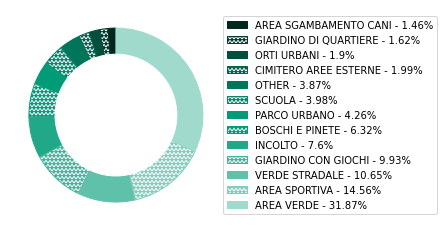

In [7]:
piechart, text = plt.pie( points_ra.percent.array, 
                         startangle = 90, 
                         colors = emeralds, 
                         wedgeprops = {
                             'linewidth' : 1
                         }
                )

for i in range(len(piechart)):
    if (i % 2 != 0):
        piechart[i].set_color('none')
        piechart[i].set_hatch('***')
        piechart[i].set_linewidth(1)
    piechart[i].set_edgecolor(emeralds[i])

donut = plt.Circle( (0,0), 0.7, color = 'white' )
p = plt.gcf()
p.gca().add_artist(donut)

labels_concat = points_ra['cat'] + ' - ' + round(points_ra['percent'], 2).astype(str) + '%'
plt.legend(piechart, labels_concat.array, bbox_to_anchor = (2, 0.5), loc = 'center right')
plt.show()

gdf of all public green areas (remove schools and streets greenery from data)

In [19]:
points_pub = points.drop(points[ points['cat'].str.contains('SPARTITRAFFICO') 
                | points['cat'].str.contains('AIUOLA')
                | points['cat'].str.contains('VIALE') ].index)
points_pub = points_pub.drop(points_pub[ points_pub['cat'].str.contains('ASILO')
                | points_pub['cat'].str.contains('SCUOLA') ].index)
# print(points.shape)
# print(points_pub.shape)

In [9]:
small_buff = points_pub[:]
small_buff['geometry'] = small_buff.geometry.buffer(500)
small_buff['dissovefield'] = 1
small_buff = small_buff.dissolve( by = 'dissovefield' )
small_buff = small_buff.overlay(areas, how='intersection')

In [10]:
big_buff = points_pub[:]
big_buff['geometry'] = big_buff.geometry.buffer(1250)
# big_buff['dissovefield'] = 1
# big_buff = big_buff.dissolve( by = 'dissovefield' )
big_buff = big_buff.overlay(areas, how='intersection')

<AxesSubplot:>

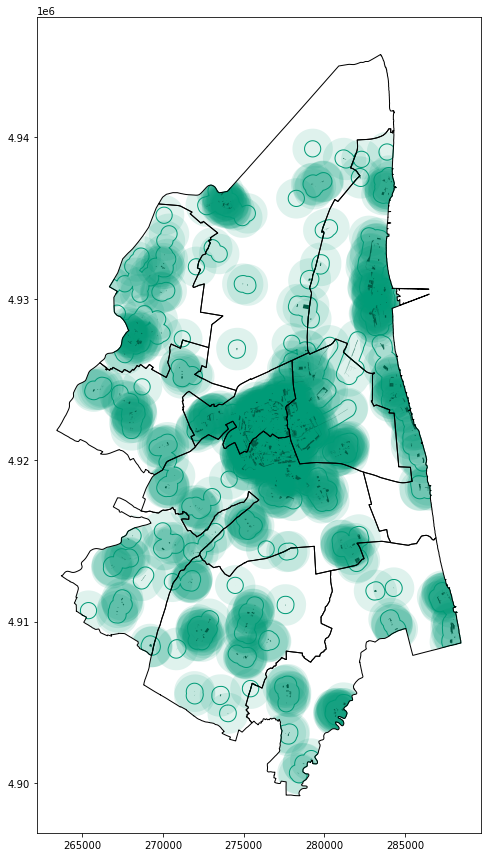

In [11]:
fig, ax = plt.subplots( figsize = (20, 15) )
big_buff.plot(ax = ax, color = '#009B7720')
small_buff.plot(ax = ax, color = 'none', linewidth = 1, edgecolor = '#009B77')
points_pub.plot(ax = ax, color = '#005C46')
areas.plot(ax = ax, color = 'none', edgecolor = 'black')